## Project Reinforcement Learning

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [1]:
# %%capture
# !rm -r BatteryGrid
# !git clone https://github.com/MaxFeucht/BatteryGrid.git
# !pip install -e BatteryGrid

# import os
# os.chdir('BatteryGrid')
# !pip install -r requirements.txt
# !pip install -e gym-env


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
import random

from utils import RuleEvaluation, DDQNEvaluation, Plotter
from agent import DDQNAgent, TemporalDDQNAgent

from TestEnv import Electric_Car

seed = 2705
TRAIN = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting up the environment:

- 50kWh of usable capacity
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh)
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [3]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) 
    return df_long.reset_index(drop=True)

train_name = 'data/train.xlsx'
val_name = 'data/validate.xlsx'

train = elongate(pd.read_excel(train_name))
val = elongate(pd.read_excel(val_name))

features_train = pd.read_csv('data/features_train.csv')
features_val = pd.read_csv('data/features_val.csv')

## RULE BASED AGENT

In [4]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = train_name

rule_env = Electric_Car(path_to_test_data=df)
eval_rule = RuleEvaluation(env = rule_env, price_horizon=price_horizon)
eval_rule.evaluate(low_quantile = 0.25, high_quantile = 0.75, null_action = False)


Absolute Balance:  -1308.4523077691176


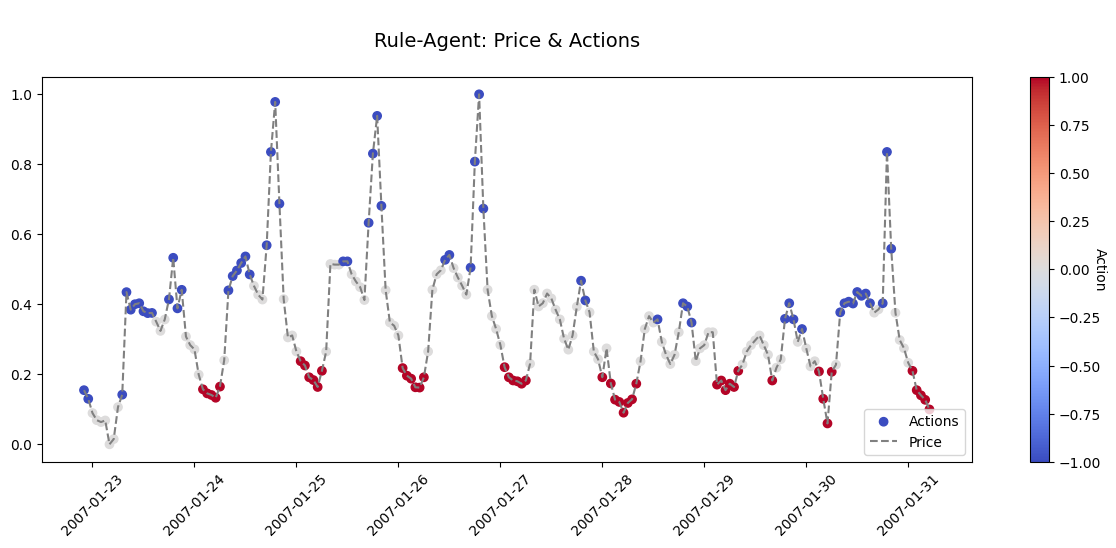

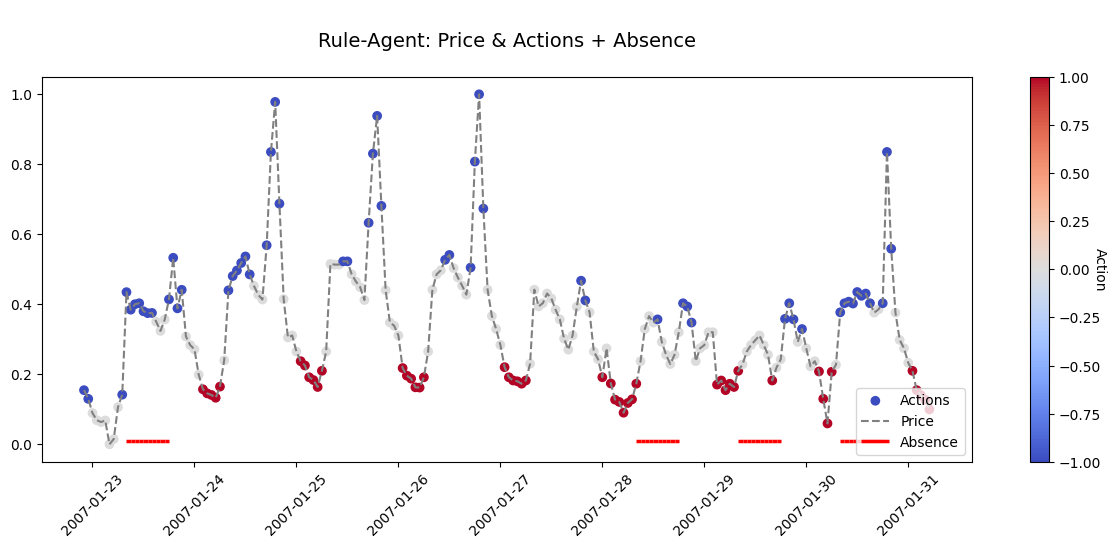

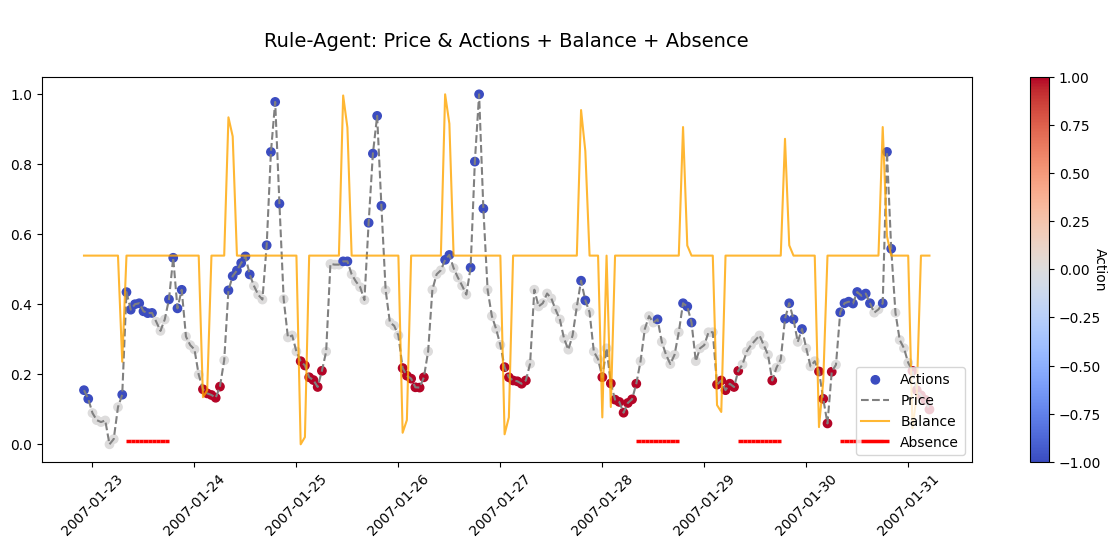

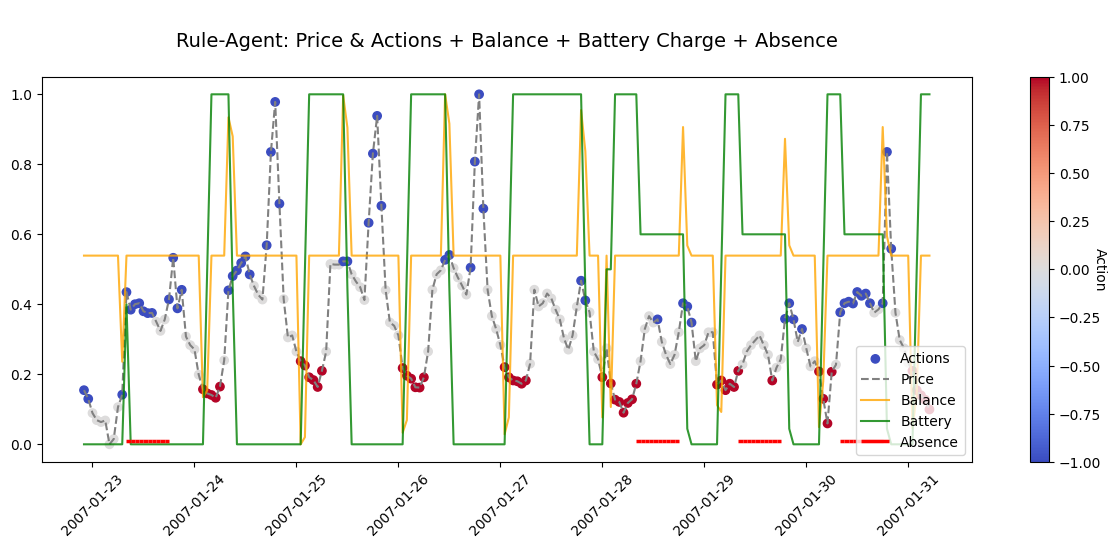

In [5]:
# Visualize Rule-Based Agent
plot_range = (500, 700)

plotter = Plotter(eval_rule, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [6]:
## NOTE: I think Environment is faulty, battery is charged while car is gone

## DDQN AGENT

In [7]:
seed = 2705
rep = 500000
batch_size = 32
gamma = 0.0
epsilon = 1.0
epsilon_decay = 29999
epsilon_min = 0.1
learning_rate = 5e-4
price_horizon = 48
future_horizon = 0
hidden_dim = 128
action_classes = 5
extra_penalty = False
verbose = False
TRAIN = True
df = train_name

In [12]:
if TRAIN:

    # Initialize Environment
    env = Electric_Car(path_to_test_data=df)

    #Initialize DQN
    agent = DDQNAgent(env = env,
                      features = features_train,
                      epsilon_decay = epsilon_decay,
                      epsilon_start = epsilon,
                      epsilon_end = epsilon_min,
                      discount_rate = gamma,
                      lr = learning_rate,
                      buffer_size = 100000,
                      price_horizon = price_horizon,
                      hidden_dim=hidden_dim,
                      action_classes = action_classes)

    obs, r, terminated, _, _ = env.step(random.randint(-1,1)) # Reset environment and get initial observation
    state = agent.obs_to_state(obs)

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    with tqdm(total=rep) as pbar:
        for i in range(rep):

            action = agent.choose_action(i, state, greedy = False) # Choose action (discrete)
            cont_action = agent.action_to_cont(action) # Convert to continuous action
            
            new_obs, r, t, _, _ = env.step(cont_action)
            new_state = agent.obs_to_state(new_obs)

            # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
            if state.shape[0] == agent.state_dim and new_state.shape[0] == agent.state_dim:
                agent.replay_memory.add_data((state, action, r, t, new_state))

            #Update DQN
            loss = agent.optimize(batch_size)
            
            # Update values
            episode_balance += r
            episode_reward += r
            episode_loss += loss

            # New observation
            state = new_state

            pbar.update(1)

            if t:
                # Reset Environment
                env.counter = 0
                env.hour = 1
                env.day = 1
                episode_counter += 1
                print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
                episode_loss = 0
                episode_balance = 0
                episode_reward = 0

    # Save agent
    torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}_hdim{hidden_dim}.pt')
    pbar.close

Number of engineered features:  41
State dimension:  139


/Users/maxfeucht/Documents/VU/Project Reinforcement Learning/BatteryGrid/agent.py:76: RuntimeWarning: invalid value encountered in divide
  return (var - np.min(var)) / (np.max(var) - np.min(var))
  0%|          | 16/500000 [00:00<57:59, 143.71it/s]

0
-2.3722222222222227
0.960525
-0.9552777777777779
0.3160125
0
0
-1.3605555555555555
0.279875
0.21239999999999998
0.0
0
0.0
-1.1106666666666667
0
0
0
0
0
0
0
0
0
0
0
9.915268606164319e-17
0.0


  0%|          | 45/500000 [00:00<1:06:40, 124.97it/s]

0
-0.611111111111111
0.25998750000000004
-0.6108333333333332
-0.4166666666666667
-0.7227777777777779
0.1625
0
0
-0.2669444444444445
-0.025185185185185126
0.325
-0.6108333333333332
0
0.55
-0.611111111111111
0.35125
-1.443888888888889
-0.6416666666666667
-0.324074074074074
-0.0
0
0.69225
-1.5383333333333336
-0.1783333333333334
-0.0
-0.0
0
-0.0
0
-0.0
0
0.151125
0.3325
-0.21777777777777776
0.155
0.09931250000000003
0
0
-0.7775
0.3103875
0.0
-0.638888888888889
0.18
0.0
0.0
0.0
0
0.0
0
-1.722222222222222


  0%|          | 91/500000 [00:00<34:16, 243.07it/s]  

0.335
0.1997
-1.0055555555555558
0.421425
0
0
0
-1.3977777777777778
-1.777777777777778
-0.0
0.413875
0.8275
0.2406000000000001
-1.9311111111111112
0.6992999999999999
-1.722777777777778
-1.613888888888889
-0.0
0.38025000000000003
-0.9580555555555557
-0.1257098765432096
0
-0.0
0.317375


  0%|          | 152/500000 [00:00<36:48, 226.33it/s]

-0.638888888888889
-0.08024691358024673
0
-0.0
0.4809999999999999
0.364
0.0
-1.1955555555555557
0
0
0
0
0
0
0
0
0
0
-1.338888888888889
-1.8544444444444446
-0.0
0
0
-0.0
0.311375
0.28150000000000003
0
-0.5722222222222223
0.45075
0
0
-0.7250185185185182
-1.6616666666666668
0.399
0.8477499999999999
-0.9416666666666667
-0.9194444444444445
-1.538814814814815
-0.0
-0.0
-0.0
-0.0
0.748
0
-2.055555555555556
0.378875
0.307625
0
0.27925
0.1197999999999999
-1.278888888888889
0
0.45832500000000004
-0.47638888888888886
0.236475
-1.277777777777778
0
0
0
0
0
0
0
0
0
0
0.130275
-2.681111111111111
0.906525
-1.8316666666666668
0
-0.7902777777777779
-0.7069444444444445
0
0.51225
0
-0.4983333333333334


  0%|          | 218/500000 [00:00<32:26, 256.78it/s]

0.4
-0.5722222222222223
-0.028654320987654403
0
0
0
0
0
0
0
0
0
0
0.0
0.0
-0.9194444444444445
0.3198375
0
0
0.0
0.0
0
0
0.0
0
0
-0.5813333333333334
0
0
0
0
0
0
0
0
0
0
-0.7977777777777777
0.38632500000000014
-0.8597222222222222
-0.7486111111111111
0.54
-1.4016666666666668
0
0.24874999999999997
0.159
-0.5016666666666666
-0.22944444444444445
-0.21805555555555556
0.17875
-0.16666666666666669
0.14875
0.051125
0.0
-0.5694444444444444
-1.2405555555555554
-0.6319444444444444
0.538
-0.4805555555555556
-0.4805555555555556


  0%|          | 258/500000 [00:01<28:11, 295.38it/s]

-0.07962962962962966
0.28075
-0.7197222222222223
0.33625
0.296375
-0.61
-0.673888888888889
0.554
0
0.2481375000000001
0.0
0.0
-0.3608333333333334
-0.7811111111111112
-0.5844444444444444
0
0
0
0
0
0
0
0


  0%|          | 290/500000 [00:01<42:34, 195.60it/s]

0
0
0
0
0.9205
0.05987999999999998
-1.4444444444444446
-1.4927777777777778
-0.0
-0.0
0.45025000000000004
0.213
0.120075
-0.44305555555555554
0.22376250000000003
-0.9640000000000003
0
0
0
0
0
0
0
0
0
0
-0.8066666666666666
0.3937500000000001
0.0
-0.7758333333333334
-0.6408333333333334
0.455175
0
0.0
0
0
0.0
0.0
0
-0.7960000000000002


  0%|          | 342/500000 [00:01<38:54, 214.01it/s]

0
0.3365
0
-0.8044444444444445
0.5021650000000002
0.0
0.0
0.0
-1.3883333333333332
0.516825
0.0
-0.8511111111111113
0
0.29373750000000004
0.0
0.0
0.0
-0.9427777777777777
-0.7772222222222223
0.1625
-0.35524691358024685
0
0.174625
0.2769500000000001
0.324
0.15383499999999997
0.0
-1.6444444444444446
0.374875
0.29960000000000003
0
0.0
-1.4416666666666669
-0.7205555555555557
0.312875
-0.8875000000000001
0.4618750000000001
0
0.4790000000000001
0
0.0
-0.4419444444444445
0
-0.335
0.24907500000000002
0.0
0.0
-1.1116666666666668
0.573975
-1.6616666666666668
0.6723
0.0
-1.7733333333333334
0.387375
-0.7761111111111112
0.5718375
0.0
0.0
-1.2738888888888888
0.6295499999999999
0.0


  0%|          | 427/500000 [00:01<27:26, 303.38it/s]

0.0
-0.61
-0.6386111111111111
0.275
-1.3322222222222222
0
-0.555
0.21275
0
-0.36111111111111116
0.2962050000000001
-0.8894444444444446
0.259
-0.7061111111111112
0
0.6485
-1.5522222222222224
0.324
-0.663888888888889
0.25075
0
0.24874999999999997
-0.6436111111111112
0.36175
-1.5372222222222225
-0.790092592592593
0.663
-0.6663888888888889
0
0
-0.4410185185185186
0.148875
0.11875000000000001
0.121125
-0.27555555555555555
0
0
0
0
0
0
0
0
0
0
-0.38833333333333336
-1.2177777777777778
0
0
0.57925
-0.6666666666666667
0.370595
-0.8816666666666666
-0.8861111111111111
0
-0.0
0.11950000000000001
-0.4775000000000001
0.5992500000000001
0.5250000000000001
0.0
0
0.0
-0.8880555555555556
0
-1.7727777777777778
0
0.36262500000000003
-1.5522222222222224
0
-0.09870370370370349
0.9500000000000001
0.6694
0.0
0.0
-1.3444444444444443
0.38205
0.0
-0.8333333333333334
0.286875
-0.33333333333333337
0.1918125
-0.9315555555555557
0
0
0
0
0


  0%|          | 503/500000 [00:02<24:51, 334.80it/s]

0
0
0
0
0
-0.7486111111111111
0.3703500000000001
0
0.0
0.0
0
0
0.0
0
0.0
0.0
0.0
0.0
-1.0297777777777781
0.5027400000000001
0.0
0.0
0
0
0.0
-1.6622222222222225
0.3625
-1.55
0.3525
-1.6611111111111112
0.431375
0.550125
-1.6644444444444446
0.324875
0
0.312875
0.2995
-0.6533333333333334
-0.6086111111111111
0.176
0.19975
2.1035972963545648e-16
-1.1555555555555557
0
-0.8330555555555555
0.79825
-1.7744444444444447
-0.8333333333333334
-0.5517037037037038
0
-0.0
0
-0.0
-0.0
0.74975
0.48274999999999996
-0.8322222222222223
0.4494375
0.0
-1.3283333333333336
0.29925
0
-1.2022222222222225
0.47400000000000003
-0.9016666666666667
-0.5722222222222223
-0.23138888888888876
0
0
0.9102499999999999
0.7001999999999999
-1.9994444444444446


  0%|          | 539/500000 [00:02<24:58, 333.25it/s]

-1.9494444444444448
0
-0.0
-0.0
0.34925
0.3375
0
-0.9702777777777778
-1.0229320987654316
-0.0
0.3375
0.6235
-0.7308333333333333
-0.6902777777777779
0.5595
0.10425000000000005
0
-0.5419444444444445
-0.5552777777777778
-1.1788888888888889
-0.0
0.36212500000000003
-0.8969135802469134
0.3745
-0.8308333333333334
0
-0.07700617283950599
0.57375
-1.2166666666666666
-0.14166666666666672
-0.0
-0.0
0
-0.0
0.347125


  0%|          | 574/500000 [00:02<41:13, 201.94it/s]

-0.7008333333333334
0.5725
0.3735000000000001
0.0
0.0
-0.6372222222222222
0
-0.4408333333333333
-0.22138888888888889
-0.0
0.44850000000000007
-1.1
0.5387500000000001
0.37835
0.0
-0.7761111111111112
0.22342499999999998
-0.4755555555555556
0
0.49410000000000004
0.0
0.0
0
0
0.0
-1.3866666666666667
0
0.5085000000000001
-1.126111111111111
-1.1327777777777779
0
-0.0
0
0
0


  0%|          | 602/500000 [00:02<51:08, 162.72it/s]

0
0
0
0
0
0
0
-0.7491666666666666
0.3865
0.8994999999999999
-2.2222222222222223
0
0
0.33775
-1.277777777777778
-0.695135802469136
0
0
-0.0
0.262375
0.33237500000000003
0
0
0
0


  0%|          | 652/500000 [00:03<48:39, 171.06it/s]

0
0
0
0
0
0
-0.6397222222222223
-1.5594444444444446
-0.7984691358024687
0
0
0
0
0.298875
-0.6790123456790123
-0.0
-0.0
0.27725
0
0.05183999999999999
0.5923799999999999
-1.7744444444444447
0
0
-1.8294444444444447
0.38825
0.774
-0.8333333333333334
-1.4444444444444446
0.6985
-1.5544444444444445
-0.44783950617283946
0.8727499999999999
0.4375
0
-0.7833333333333334


  0%|          | 674/500000 [00:03<56:51, 146.38it/s]

0.44906250000000003
-0.611111111111111
-1.2194444444444443
0.524
0
-0.4444444444444445
-1.2722222222222221
0
0
0
0
0
0
0
0
0
0
0
0.32987500000000003
0
0.43068
0
0.0
0
0.0
0
-1.3055555555555556
-1.2172222222222222
0.260875
0.5375
0
-0.6974074074074071
-0.8333333333333334
-0.915
0.432625
0.8477499999999999
-1.8394444444444447
0.7875
0.014954999999999948
0
0.0
0


  0%|          | 740/500000 [00:03<39:31, 210.52it/s]

0
0.0
0
0
0
-1.443888888888889
0
0.29962500000000003
0.2302
0.0
-0.9977777777777779
0.31455
-0.38777777777777783
-0.317
0
0
0
0
0
0
0
0
0
0
-0.581388888888889
-0.7194444444444444
0.65475
0.0
-1.3866666666666667
0.326125
0
-1.3844444444444446
-0.5738888888888889
0.5015
0
0.0885
0
-0.33333333333333337
0
0
0
0
0
0
0
0
0
0
0
0.32389750000000006
-1.0811111111111111
0.43256250000000007
0.0
-0.8405555555555557
-0.775
0.28325
-0.6983333333333334
0
0
-0.2752777777777778
-0.677469135802469
-0.0
0
0
0
0
0
0
0
0
0
0
-0.86
0.4495
0
-1.8979074074074076


  0%|          | 822/500000 [00:03<28:49, 288.55it/s]

0.43125
-1.0132716049382713
0.7035
0.46380000000000005
0.0
-0.638888888888889
-0.5758333333333334
0.23750000000000002
0.23010000000000003
-1.2475555555555558
0.433625
-1.8877777777777776
-1.4523456790123455
0
-0.0
-0.0
0.8737500000000001
-0.9427777777777777
0.404125
0.41224999999999995
-0.8886111111111111
-1.1111111111111112
-1.4669444444444446
-0.5014814814814816
-0.0
-0.0
0
-0.0
0.26737500000000003
0.263125
-1.1666666666666667
-0.1343827160493824
0
0
0
0
0
0
0
0
0
0
0
0
-1.3577777777777782
0.8765000000000001
-2.787777777777778
-0.24679012345679022
0.386
-1.028888888888889
0.848
-1.337777777777778
0
0
-0.189074074074074
0
-0.0


  0%|          | 855/500000 [00:03<36:35, 227.34it/s]

0
0.382625
-1.0130555555555556
-0.11391975308641948
-0.0
-0.0
-0.0
0.4375
0.41250000000000003
0.6216
0.0
0.0
-2.0050000000000003
-3.0333333333333337
-0.0
-0.0
0
-0.0
0.325
0
0.27675
0.44880000000000014
0.0
0.0
-1.3337777777777782
0
0
0
0
0
0
0
0
0
0
8.965628239820945e-17
-1.777777777777778
-1.1388888888888888
0
0.375
0
0.3825
-1.6
-0.7998765432098766
0.5405
0.42
0.0
0
-0.8177777777777778
0.257125
0.16483500000000006


  0%|          | 883/500000 [00:04<57:02, 145.85it/s]

0.0
0.0
0
0.0
0.0
0
0.0
0.0
0.0
-0.861111111111111
-2.222777777777778
0
0.82775
0.3325
-1.9388888888888889
0.3365
-0.6572222222222223
-1.4416666666666669
-0.06799382716049367
0


  0%|          | 905/500000 [00:04<1:01:54, 134.35it/s]

-0.0
0.1885
0
0
0
0
0
0
0
0
0
0
0.262
-0.7475
-0.8305555555555556
0.7095200000000002
0.0
0.0


  0%|          | 940/500000 [00:04<1:12:33, 114.63it/s]

-0.6944444444444444
-0.6225
0.27475
0
-0.5666666666666667
-1.2172222222222222
0
0
0
-0.10182098765432077
0
0.79925
0.6397999999999999
-1.7766666666666668
0.675
-1.6644444444444446
0.325
0.24010000000000004
0.0
0.0
-1.3333333333333335
0.6741
-1.5511111111111113
0.349375
-0.7197222222222223


  0%|          | 954/500000 [00:05<1:22:08, 101.26it/s]

-1.3894444444444447
-0.06790123456790108
0.252875
-0.5805555555555555
0
-0.0
0.70075
0
0
0
0
0
0
0
0
0


  0%|          | 980/500000 [00:05<1:05:43, 126.55it/s]

0
0.05391999999999998
0
0.0
-0.972777777777778
-0.8266666666666668
0.651825
0.0
0
-0.6138888888888889
0.2475
-0.5663888888888889
-1.0533333333333335
0.5795
-0.7497222222222222
0
0
0
0
0
0
0
0
0
0
0
-1.5555555555555556
0
0.4578750000000001
-0.8583333333333334
0.69657
-0.75
-1.28
0
-0.5947222222222223
0
-0.0


  0%|          | 996/500000 [00:05<1:03:41, 130.58it/s]

-0.0
0
-0.0


  0%|          | 1011/500000 [00:05<1:26:46, 95.83it/s]

-0.0
-0.0
0.9265
0.43899999999999995
0
-0.9166666666666667
0.5934375000000001
0.0
0.0
-1.5555555555555556
0
0
0.43724999999999997
0.29940000000000005
-1.6116666666666668
0.6255000000000001
0.0
-0.6897222222222222
0.260775
0.0
-0.4702777777777778
0.2691
-1.498888888888889
-1.9400000000000002


  0%|          | 1042/500000 [00:05<1:19:41, 104.36it/s]

0
1.00025
0.8200000000000001
0.0
-2.3294444444444444
0.4497499999999999
0.33920000000000006
0.0
-0.8052777777777778
-1.5538888888888889
0.749
0
-1.941666666666667
-1.0500925925925926
-0.0
-0.0
0.7235
-1.4983333333333333
0
-0.14512345679012353
-0.0
-0.0
0
0.6995
0.374875
-0.9444444444444445
0


  0%|          | 1075/500000 [00:06<1:09:51, 119.04it/s]

0.6751875
0.0
0.0
0
0.0
0
-0.7205555555555557
-1.55
0.36175
0.6383500000000001
-1.5538888888888889
0.675
0.0
0.0
0.0
0.0
-0.6952777777777779
0.2619
-1.3855555555555557
-0.7202777777777778
0
0
0.69825
0.2536625
0.0
-0.8325
-1.4994444444444444
-0.6344444444444445
0.548
-1.606111111111111
-0.12345679012345684
0


  0%|          | 1089/500000 [00:06<1:28:57, 93.48it/s] 

0.749
0
0
0.6581999999999999
0.0
0.0
0.0
0
-0.5961111111111113
0.2428875
0.0


  0%|          | 1103/500000 [00:06<1:21:24, 102.14it/s]

-1.4662222222222225
0.51575
-2.592777777777778
0
1.2775
-2.950555555555556
-1.3841666666666668
0.58325
0
0.9668475000000001
0.0
0
0.0
-0.9163888888888889
0.47655000000000003
0.0
0.0
0
0.0
-1.25
0
0
-1.0483333333333336


  0%|          | 1145/500000 [00:06<1:02:05, 133.91it/s]

0.3055
0.41107500000000013
0
0
0
0
0
0
0
0
0
0
-0.8019444444444445
-1.6394444444444447
0.374625
-1.0566666666666669
-0.8627777777777778
0.400125
-0.826388888888889
0.36275
-0.9629629629629625
-0.0
0.2885
0
-0.8055555555555555
0.75
0
0
0
0
0
0
0
0
0
0
0.06321999999999998
-1.7272222222222222
-1.7833333333333334
-0.0


  0%|          | 1176/500000 [00:06<1:05:27, 127.01it/s]

-0.0
-0.0
0.777
0.33775
-1.393888888888889
0.3125
0.4311999999999999
-1.2838888888888889
-0.75
-0.7783333333333334
0.46237500000000004
-1.1422222222222222
-0.13253086419753055
1.027
-1.108888888888889
-1.2894444444444446
-0.0
0.849
0.6196
0.0
0
0
0
0.0
0.0
-1.83
0.7069500000000001
-1.61
0.5868
-1.3555555555555554


  0%|          | 1194/500000 [00:07<1:13:24, 113.25it/s]

0.288625
-1.2216666666666665
-0.6691666666666667
0
0.4493750000000001
-1.4802469135802463
-0.0
-0.0
-0.0
-0.0
-0.0
0
-0.0
-0.0
-0.0
0.333625
-0.7483333333333334
0.383125


  0%|          | 1232/500000 [00:07<58:20, 142.50it/s]  

0.359125
0.375
-0.8305555555555556
0
-0.803611111111111
0
0
0.5735
0.09378750000000012
-1.4416666666666669
0
0
0
0
0
0
0
0
0
0
0
-0.8033333333333333
-0.8052777777777778
-0.8605555555555555
0
0.8227499999999999
0.39697
4.46842562951133e-17
0.0
0.0
-0.6919444444444445
0
-0.5833333333333334
-0.6369444444444444
0
0
0
0
0
0
0
0
0


  0%|          | 1276/500000 [00:07<48:54, 169.96it/s]

0
0.33200999999999997
-1.2872222222222225
0.605475
0.0
-1.6105555555555555
0
-0.8033333333333333
0
-0.6044444444444445
0.532
0.44
0.0
0
-0.7333333333333334
-0.4063888888888889
0
-0.9317777777777777
0.278125
-0.7222222222222223
-0.08033950617283932
0
-0.0
-0.0
0
-0.0
-0.0
0
-0.0
0.724
0
0.37375
0.16559999999999997
0.0
-0.4730555555555556
0.11306250000000001
0
0.0
-1.2435555555555557
0
-1.0552777777777778
0.49974999999999997


  0%|          | 1337/500000 [00:07<35:12, 236.06it/s]

0.49937500000000007
0
-2.2172222222222224
-1.043611111111111
-0.6379506172839507
0.87475
0.6598
-1.8316666666666668
0.42425
-0.9425
0
0.449625
0
0.28
0.0
-1.3911111111111112
0.54
0.0
0
-0.6969444444444445
-0.5015000000000001
0
0
0
0
0
0
0
0
0
0
0.0
0.0
-1.8333333333333335
0
0.417875
0
0.2905
0.0
-0.7222222222222223
0.2818125
0
0.0
0
-1.2862222222222224
0
0
0
0
0
0
0
0
0
0
1.0583534049146694e-16
-1.8855555555555554
0
-1.941666666666667
0
0.41312499999999996
-0.8919753086419752
0.7005
-1.3816666666666668
0.275
0
-0.38861111111111113
-0.23074074074074102
0.7255
0
0


  0%|          | 1406/500000 [00:08<29:33, 281.12it/s]

0
0
0
0
0
0
0
0
-0.8886111111111111
0.41200000000000003
-0.8958333333333334
-1.8305555555555557
-0.8034444444444448
0.751
-1.6127777777777779
0
-0.12962962962962968
-0.0
0.47500000000000003
-0.8327777777777778
-0.11728395061728401
-0.0
-0.0
0
0.7745
0
-0.9163888888888889
0
0
0
0.3125
-0.6772222222222222
-0.6944444444444444
0.343125
-1.1150308641975313
0.74775
0.5700000000000001
0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.28622222222222227
-0.27222222222222225
0.21150000000000002
0
0.57375
-0.6933333333333334
0.37890749999999995
0.0
-0.6088888888888889
-1.0522222222222224
0.42300000000000004
0
0.1920625
0
0.0
0.0
0
0
-1.2022222222222225
0
0.429525


  0%|          | 1474/500000 [00:08<27:07, 306.39it/s]

0
-0.5105555555555555
0
0
0
0
0
0
0
0
0
0
0
0
-0.9177777777777778
-0.9319444444444444
0.412875
0.4875
-2.111111111111111
0.8579900000000001
0.0
0.0
0
-0.5555555555555556
-0.528888888888889
-0.4538888888888889
-0.0
0.31625000000000003
0.41224999999999995
-2.2172222222222224
-0.26493827160493766
0
0
0
1.12275
-2.3305555555555557
0
-0.2035185185185186
-0.0
-0.0
-0.0
-0.0
-0.0
0
0
-0.0
0.5935
-0.5419444444444445
0.22574999999999998
0.21487500000000004
0
-0.7691172839506174
0
0
0
0
0
0
0
0
0
0
-0.8594444444444445
0
0.35988749999999997
-2.0
0.436625
0.32060000000000005
0.0
0


  0%|          | 1551/500000 [00:08<24:11, 343.50it/s]

0.0
0.0
-1.0561111111111114
0.28035000000000004
0
-1.588888888888889
0
0
0
0
0
0
0
0
0
0
0.12604500000000002
0.0
-0.7230555555555557
-0.8336111111111112
0
0.6273
0.0
0.0
0
-0.5019444444444444
0.19192499999999998
0.0
0
-1.378888888888889
-0.803611111111111
0
0.47437500000000005
0
-1.026388888888889
0
0.8492500000000001
0.24705000000000008
0.0
0.0
-0.7211111111111113
-1.555
0
0
0
-0.8
-0.0
-0.0
-0.0
0.28975
-0.6069444444444445
-0.04382716049382706
-0.0
0.275
0
0
0
0
0
0
0
0
0
0
0
0.39092000000000016
0
0
0.0
-1.663888888888889
-1.5
-0.0
-0.0
0
0
-0.0


  0%|          | 1589/500000 [00:08<23:27, 354.14it/s]

-0.0
-0.0
0
0
0
0
0
0
0
0
0
0
-0.5269444444444444
0.298875
0.6072500000000001
0.019477499999999974
-1.6111111111111112
0.618525
0
0
0.0
-0.59
0.22713750000000002
0.0
0.0
-1.75
-1.1658333333333333
0
1.246
0
-2.9961111111111114
1.35525
-1.3944444444444446
0.844375
-1.3527777777777779
-1.2475
-1.0963888888888889
-1.0830555555555557
0
1.0255
0.8192
0.0
0.0
-0.6436111111111112
-0.5997222222222223
0.251
-1.113888888888889
0.11725000000000002


  0%|          | 1657/500000 [00:08<30:36, 271.39it/s]

-1.3888888888888888
-0.927037037037037
0
-0.0
-0.0
-0.0
0.550875
0
-1.2675925925925924
-0.0
0
0.99825
0.484375
0.2814
0.0
0.0
0.0
-1.7244444444444444
0.609525
-1.6022222222222222
0.2795
-1.156111111111111
-0.5477777777777777
0.024
0.3697500000000001
-0.9786666666666668
0.4672800000000001
0.0
0
0
-2.115555555555556
0.47525000000000006
0.3707
0.0
-0.946388888888889
-0.8627777777777778
0.676575
0
0.0
0.0
-1.7744444444444447
-0.861388888888889
-0.7236111111111112
-0.0
0.527
0.4056
0
0.0
0
-1.160888888888889
0
0
0
0
0
0
0
0
0
0
1.2150280781497714e-16
0.0
-1.9444444444444446
0.810225
-1.9972222222222225


  0%|          | 1710/500000 [00:09<43:29, 190.96it/s]

0.38175000000000003
0.2536
0.0
0
0
0.0
-0.5094444444444445
-1.2772222222222223
0
-0.0
0
-0.0
-0.0
0.9237500000000002
0
-0.9447222222222222
-0.9191666666666668
0.77725
-0.7916666666666667
0.6875
0.11399999999999993
0.0
0
-1.8838888888888887
0.6975
0.0
0
0.0
-0.75
0
0
0.000125
-0.375
0
0.18575
0
0.174125
0
0.0


  0%|          | 1757/500000 [00:09<41:31, 200.01it/s]

0
-0.4972222222222222
-0.9944444444444444
0
0.2765
-0.4972222222222222
-0.45333333333333337
0.39525
0.209875
-0.7283333333333334
0.4459000000000001
0.0
-0.1777777777777778
0
-0.0005555555555555556
-0.0
0.000125
0
0.00025
0
-0.0005555555555555556
-0.19916666666666666
0
-0.12944444444444436
-0.0
0
-0.0
-0.0
-0.0
-0.0
0.26025
0.069125
-0.23222222222222222
-0.6944444444444444
0.2715
0
0
-0.3352777777777778
0.25075
0.018974999999999975
0
-0.840888888888889
0
0
0
0
0
0
0
0
0


  0%|          | 1788/500000 [00:09<37:19, 222.49it/s]

0
8.217426739065558e-17
-1.4972222222222222
0.329125
0
0.2695
0.0
0.0
0.0
-0.8361111111111112
-0.7266666666666668
0.151
-0.19166666666666662
0
0.20074999999999998
0
0
0
0
0
0
0
0
0
0
0.021999999999999992


  0%|          | 1833/500000 [00:09<46:49, 177.30it/s]

0.0
0.0
0.0
0.0
0
-0.528888888888889
0
-0.7277777777777779
0.30225
-0.18583333333333335
-0.668888888888889
-0.11086419753086425
-0.0
0
0
0
0
0
0
0
0
0
0
-0.973888888888889
-0.5515000000000001
0.38775
-0.9506172839506172
0.79925
0
-0.6727777777777777
-0.821604938271605
-0.0


  0%|          | 1853/500000 [00:10<55:05, 150.70it/s]

0.52125
-0.5075000000000001
0.15375
-1.2961111111111112
-0.23935185185185218
0
0
0
0
0
0
0
0
0
0
0
0.411625
0.45298
0.0
0.0
0.0
0
-1.3888888888888888
0


  0%|          | 1887/500000 [00:10<54:44, 151.65it/s]

0.2635
-0.5666666666666667
0
0.48747500000000005
-1.461111111111111
0.462625
0.431
-2.61
-2.7683333333333335
-0.0
0.6025
1.09225
-1.110277777777778
-1.9883333333333333
0.387
0.375
0.5022875000000001
0
-0.7777777777777778
0
0
-1.5033333333333332
0
0.276
0
-0.5355555555555557
-0.4419444444444445
-0.060216049382715915
-0.0
0
0
0
0
0


  0%|          | 1936/500000 [00:10<44:28, 186.62it/s]

0
0
0
0
0
0.598
-1.3333333333333335
-0.6683333333333333
0.62375
-0.7016666666666668
0.5946600000000001
0.0
-0.7227777777777779
0.25875
0
0.0
0.0
0.0
-1.077777777777778
0
0
0
0
0
0
0
0
0
0
-1.1683333333333334
0.5725
-0.6655555555555556
0.373875
0.02399999999999997
-0.9719444444444446
-1.4316666666666669
0
-0.4805555555555556
0.40225
0
-0.39
0.45
-0.023543209876543278
0
0
0
0


  0%|          | 1956/500000 [00:10<44:22, 187.04it/s]

0
0
0
0
0
0
-0.8972222222222221
0.3715875
0.0
0.0
-0.8586111111111111
0.35235000000000005
-1.4483333333333335
0
-1.077777777777778
0.22574999999999998
0.42675
0.12037500000000005
-0.45055555555555554
-0.2486666666666667
0
0
0
0
0
0
0
0
0
0
-1.396111111111111
-1.5516666666666667
0.325625
-0.8632716049382715
0.73975
0
0
0.23762500000000003
0.12817499999999998
0.0
0.0
-0.375
0.4437


  0%|          | 2002/500000 [00:10<43:37, 190.26it/s]

-1.0591111111111111
0
0
0
0
0
0
0
0
0
0
1.0570744279903011e-16
-1.8922222222222225
-1.7822222222222222
0.875
-1.927777777777778
0.40062499999999995
0.7252500000000001
0
0.1003999999999999
0.0
-0.7177777777777778
-0.508888888888889
0.45525
-1.2783333333333335
0
0
0
-0.28314814814814826
0
0.610375
-1.2472222222222222
-0.12160493827160465
0.47500000000000003
0
0
0
0
0.774
0.2625000000000001
0.0
-1.5150000000000001
0
0.47250000000000003
-1.0594444444444446
-0.46888888888888886
-0.4419444444444445
-0.0
0.6025
-0.9730555555555557
-1.3254320987654322
0.500625
-1.3395061728395061


  0%|          | 2034/500000 [00:11<45:01, 184.30it/s]


KeyboardInterrupt: 

In [11]:
torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}_hdim{hidden_dim}_newenv.pt')

In [9]:
price_horizon = 96
hidden_dim = 64

# Initialize Environment
env = Electric_Car(path_to_test_data=df)

#Initialize DQN
agent = DDQNAgent(env = env,
                    features = features_train,
                    epsilon_decay = epsilon_decay,
                    epsilon_start = epsilon,
                    epsilon_end = epsilon_min,
                    discount_rate = gamma,
                    lr = learning_rate,
                    buffer_size = 100000,
                    price_horizon = price_horizon,
                    hidden_dim=hidden_dim,
                    action_classes = action_classes)

agent.dqn_predict.load_state_dict(torch.load(f'models/agent_{action_classes}_hdim{hidden_dim}_newenv.pt'))


Number of engineered features:  41
State dimension:  139


/Users/maxfeucht/Documents/VU/Project Reinforcement Learning/BatteryGrid/agent.py:76: RuntimeWarning: invalid value encountered in divide
  return (var - np.min(var)) / (np.max(var) - np.min(var))


<All keys matched successfully>

Absolute Balance:  -427.3559402777779


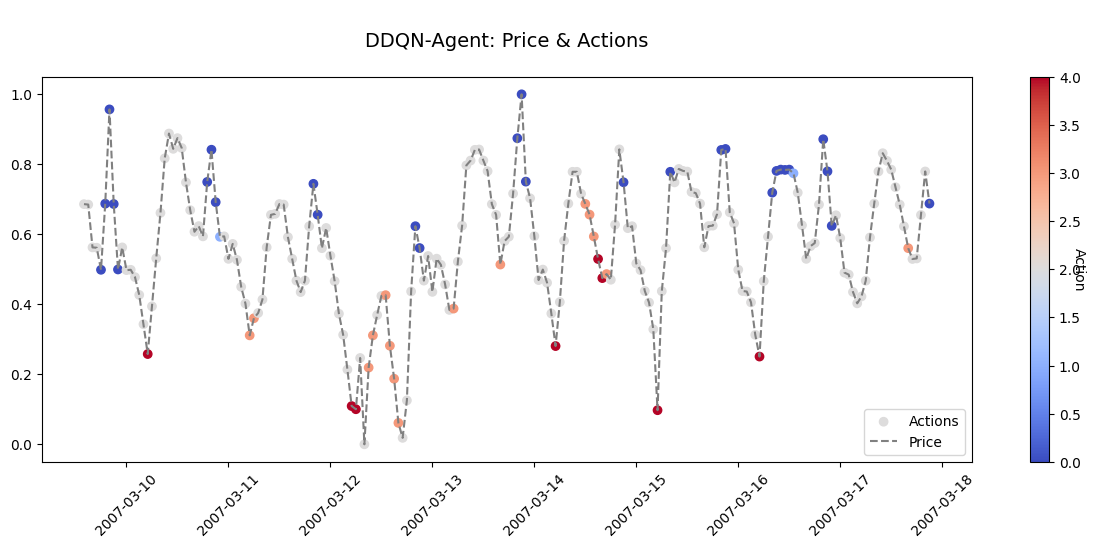

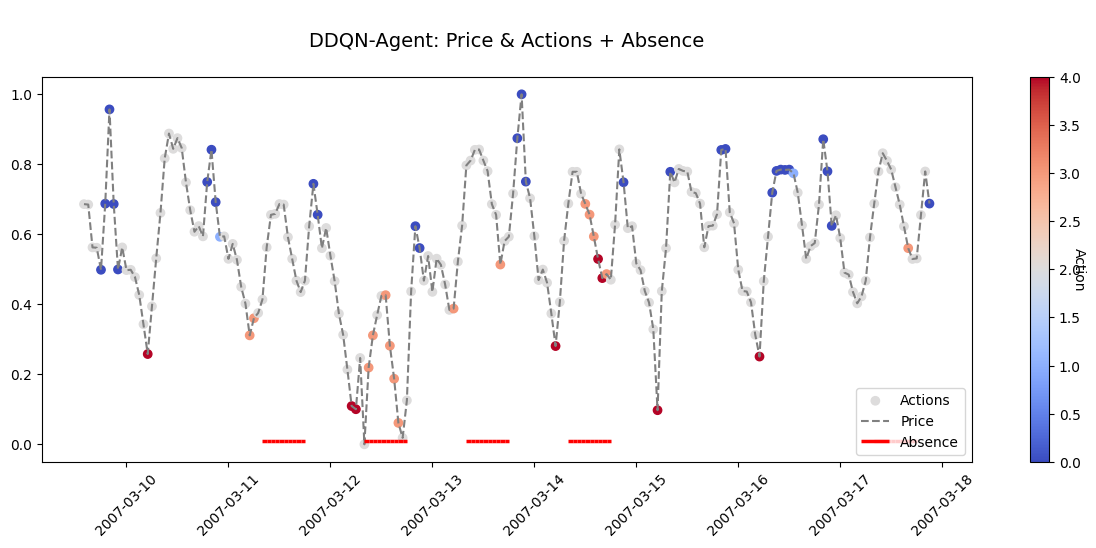

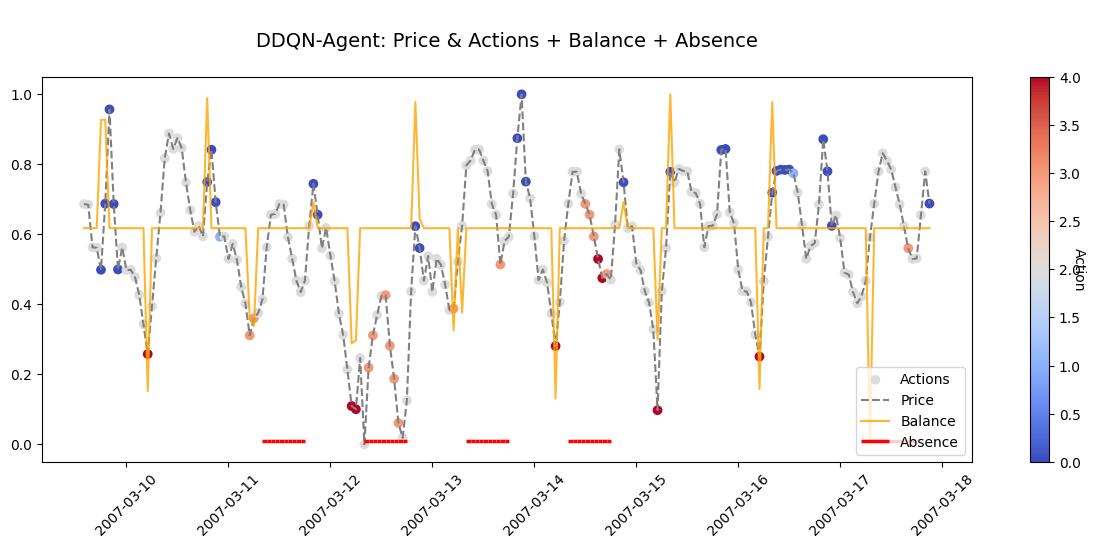

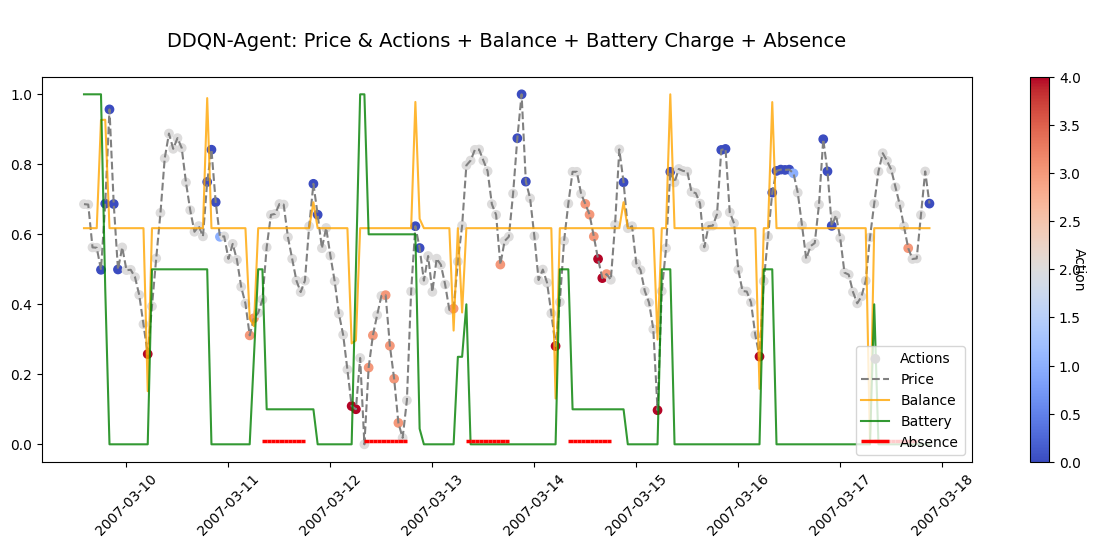

In [11]:
# Evaluate Rule-Based Agent
price_horizon = 96
df = train_name

eval_ddqn = DDQNEvaluation(price_horizon=price_horizon)
eval_ddqn.evaluate(agent = agent)

# Visualize Rule-Based Agent
plot_range = (500, 700)

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)


In [ ]:
#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

# VALIDATION

Setup with price horizon:  24  and future horizon:  0  and action space:  13
Absolute Balance:  -1069.6851857126667


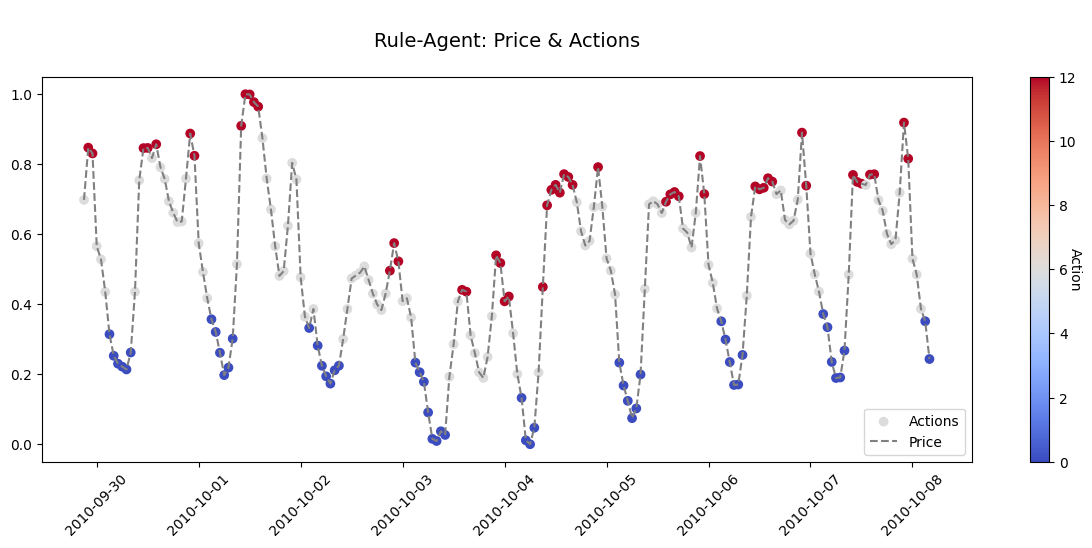

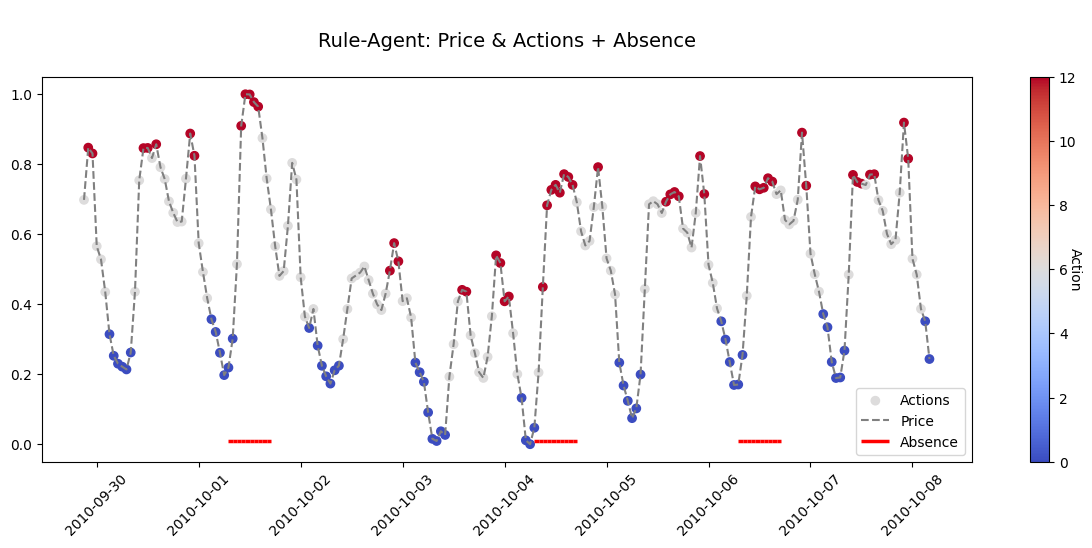

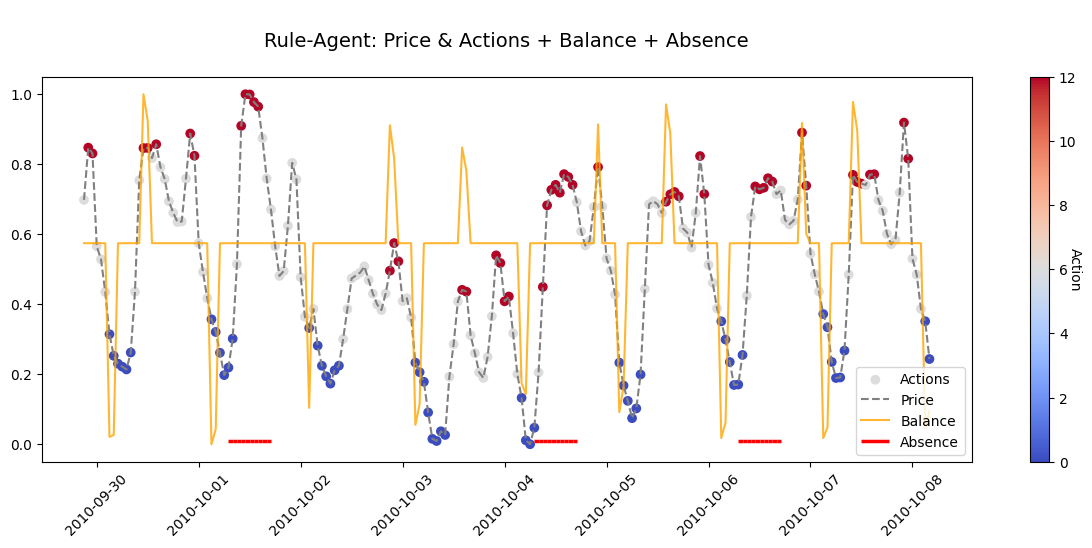

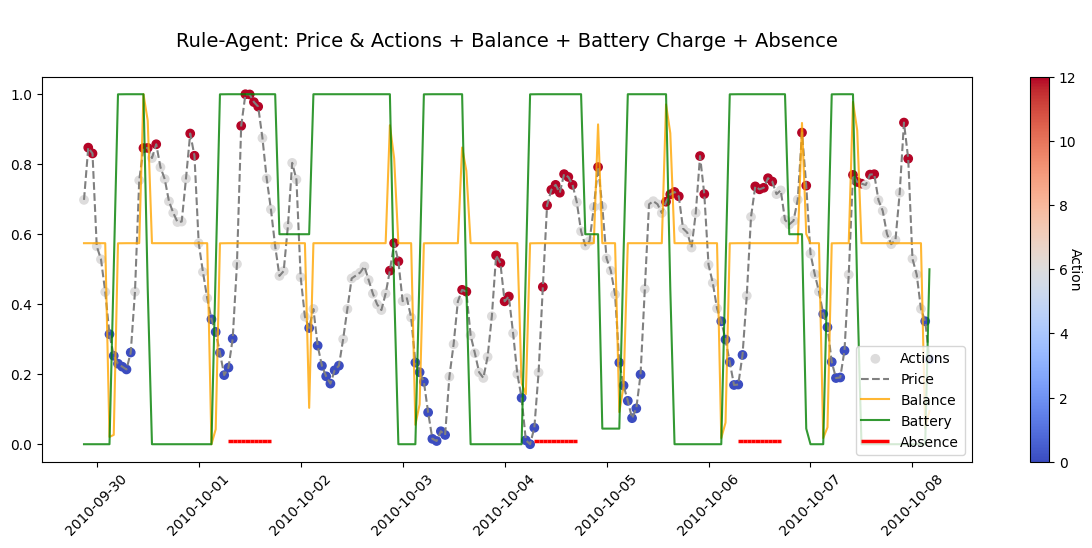

In [ ]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = val

rule_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env_val.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_rule_val = RuleEvaluation(df, rule_env_val)
eval_rule_val.evaluate(low_quantile = 0.25, high_quantile = 0.75)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_rule_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)


Setup with price horizon:  24  and future horizon:  0  and action space:  3
Absolute Balance:  -3629.2038476761113


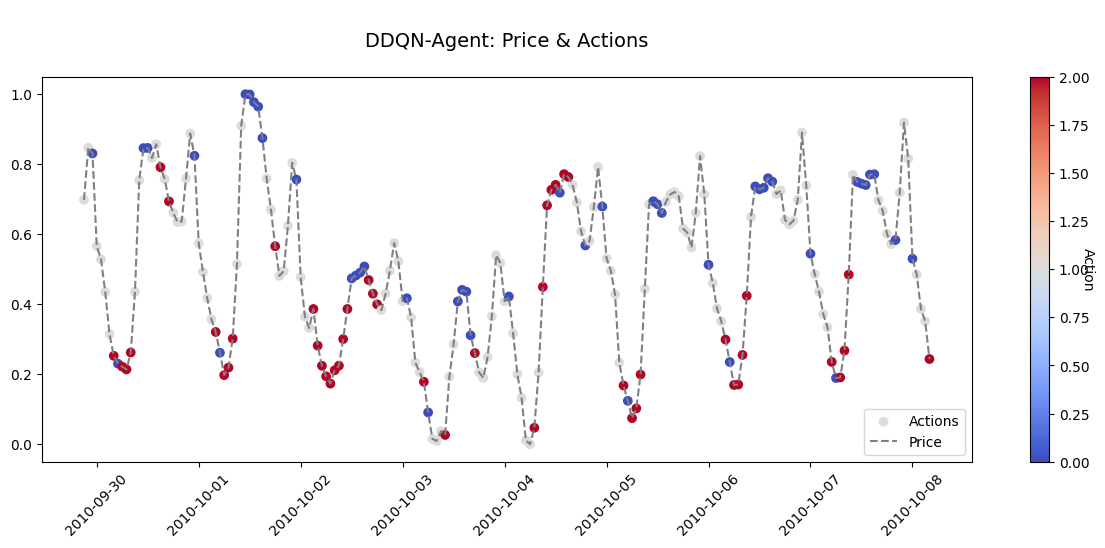

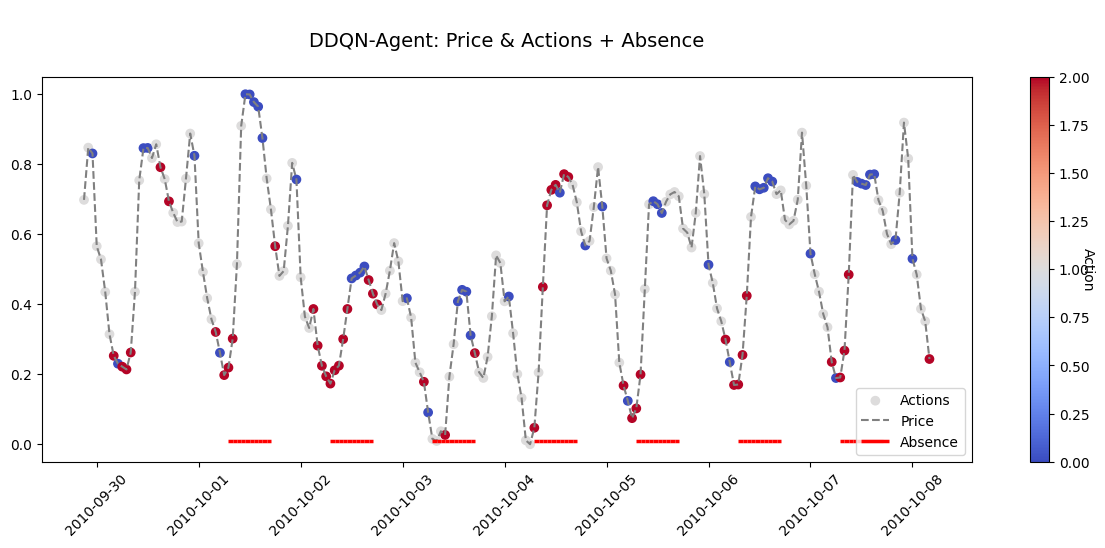

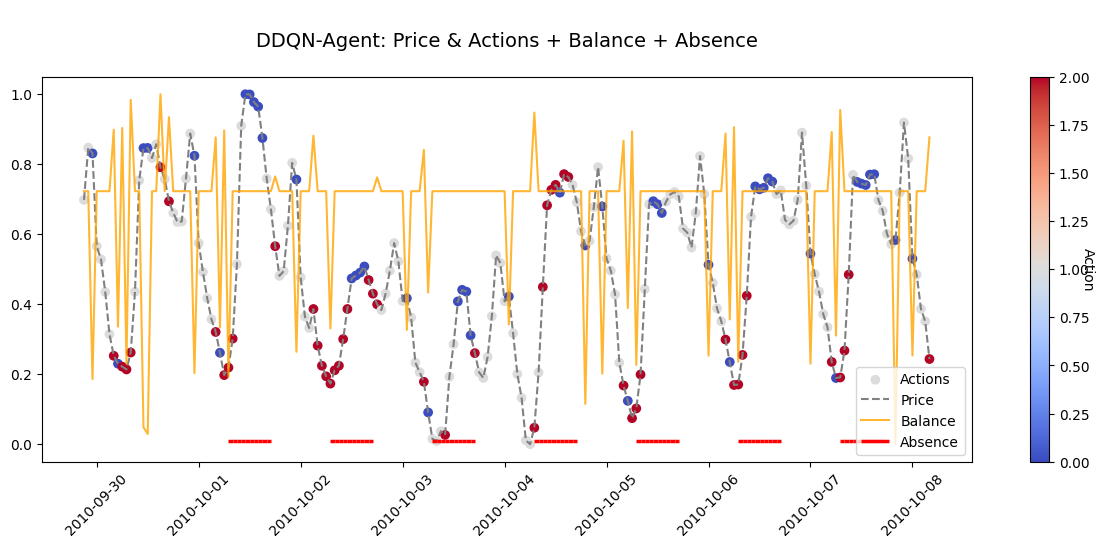

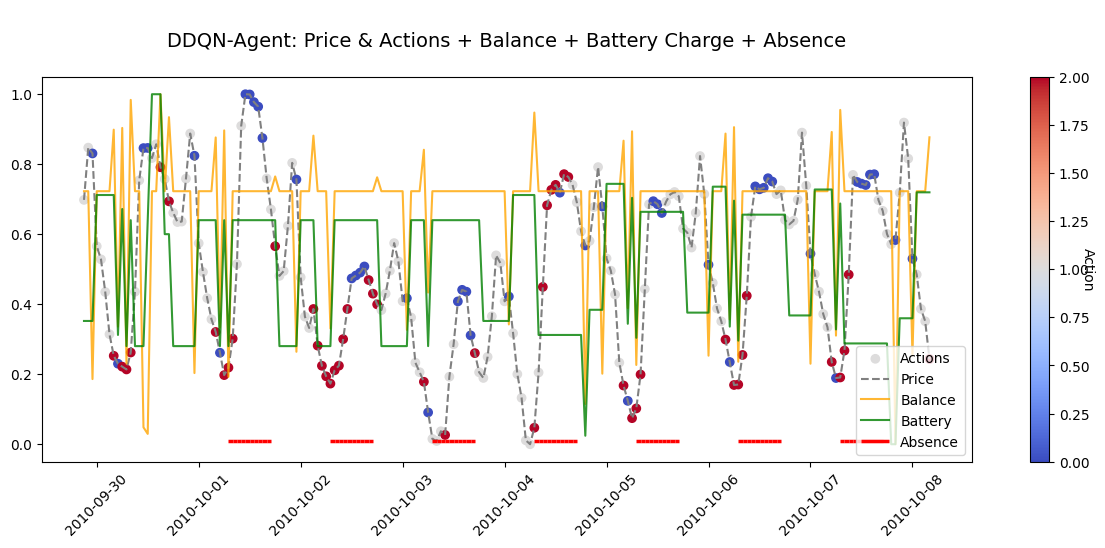

In [ ]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = val

ddqn_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env_val.setup(df, price_horizon=price_horizon, action_classes = 3)
eval_ddqn_val = DDQNEvaluation(df, ddqn_env_val)
eval_ddqn_val.evaluate(agent = agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [ ]:
## To Do:

# Improve efficiency of environment
#

# TEMPORAL AGENT



In [8]:
epsilon = 1
epsilon_min = 0.05
epsilon_decay = 99999
gamma = 0.99
learning_rate = 5e-5
lin_hidden_dim = 32
temp_hidden_dim = 16
kernel_size = 3
dropout = 0.1
action_classes = 5
price_horizon = 120
future_horizon = 0
extra_penalty = False
verbose = False
TRAIN = True
rep = 2000000
batch_size = 32

In [9]:
if TRAIN:

    # Initialize Environment
    env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
    env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

    #Initialize DQN
    temporal_agent = TemporalDDQNAgent(env = env,
                            device = device,
                            epsilon_decay = epsilon_decay,
                            epsilon_start = epsilon,
                            epsilon_end = epsilon_min,
                            discount_rate = gamma,
                            lr = learning_rate,
                            buffer_size = 100000,
                            price_horizon = price_horizon,
                            lin_hidden_dim = lin_hidden_dim,
                            temp_hidden_dim = temp_hidden_dim,
                            kernel_size = kernel_size,
                            dropout = dropout,
                            action_classes = action_classes)

    obs, info = env.reset() # Reset environment and get initial observation

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    with tqdm(total=rep) as pbar:
        for i in range(rep):

            action = temporal_agent.choose_action(i, obs['tensor'], greedy = False)
            new_obs,r,t,info = env.step(action)

            # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
            temporal_agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))

            #Update DQN
            loss = temporal_agent.optimize(batch_size)

            # Update values
            episode_balance += info['balance']
            episode_reward += r
            episode_loss += loss

            # New observation
            obs = new_obs

            pbar.update(1)

            if i % 200000 == 0:
              torch.save(temporal_agent.dqn_predict.state_dict(), f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt')

            if t:
                obs, info = env.reset()
                episode_counter += 1
                print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
                episode_loss = 0
                episode_balance = 0
                episode_reward = 0

    # Save agent
    torch.save(temporal_agent.dqn_predict.state_dict(), f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt')
    pbar.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Setup with price horizon:  120  and future horizon:  0  and action space:  5


  1%|▏         | 26203/2000000 [04:17<5:44:18, 95.55it/s]

Episode  1 Balance:  -7872.259392918585 Reward:  -7872.259392918585 Loss:  364551.5186349079


  3%|▎         | 52384/2000000 [08:51<5:14:27, 103.23it/s]

Episode  2 Balance:  -7391.0569275228045 Reward:  -7391.0569275228045 Loss:  740323.4686083794


  4%|▍         | 78566/2000000 [13:45<5:46:56, 92.31it/s]

Episode  3 Balance:  -5187.653382293564 Reward:  -5187.653382293564 Loss:  296431.74337768555


  5%|▌         | 104747/2000000 [18:53<7:42:31, 68.29it/s]

Episode  4 Balance:  -2164.047174287446 Reward:  -2164.047174287446 Loss:  61720.66595456004


  7%|▋         | 130937/2000000 [24:08<5:39:48, 91.67it/s]

Episode  5 Balance:  -1640.1887859755586 Reward:  -1640.1887859755586 Loss:  19395.118714027107


  8%|▊         | 157122/2000000 [29:24<5:36:32, 91.27it/s]

Episode  6 Balance:  -1591.9041785640034 Reward:  -1591.9041785640034 Loss:  7180.21764674969


  9%|▉         | 183299/2000000 [34:38<7:13:47, 69.80it/s]

Episode  7 Balance:  -1239.6413901954409 Reward:  -1239.6413901954409 Loss:  4170.589608972892


 10%|█         | 209483/2000000 [39:55<6:06:38, 81.39it/s]

Episode  8 Balance:  -1322.1944263822252 Reward:  -1322.1944263822252 Loss:  3672.9510052036494


 12%|█▏        | 235670/2000000 [45:13<5:56:13, 82.55it/s]

Episode  9 Balance:  -1246.4233044127761 Reward:  -1246.4233044127761 Loss:  2785.1822051750496


 12%|█▏        | 244883/2000000 [47:05<5:37:28, 86.68it/s]


KeyboardInterrupt: 

In [11]:
# Initialize Environment
env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

#Initialize DQN
temporal_agent = TemporalDDQNAgent(env = env,
                        device = device,
                        epsilon_decay = epsilon_decay,
                        epsilon_start = epsilon,
                        epsilon_end = epsilon_min,
                        discount_rate = gamma,
                        lr = learning_rate,
                        buffer_size = 100000,
                        price_horizon = price_horizon,
                        lin_hidden_dim = lin_hidden_dim,
                        temp_hidden_dim = temp_hidden_dim,
                        kernel_size = kernel_size,
                        dropout = dropout,
                        action_classes = action_classes)


temporal_agent.dqn_predict.load_state_dict(torch.load(f'models/temp_agent_{action_classes}_hdim{temp_hidden_dim}.pt'))

Setup with price horizon:  120  and future horizon:  0  and action space:  5


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

Setup with price horizon:  120  and future horizon:  0  and action space:  5
Absolute Balance:  -804.7023359922223


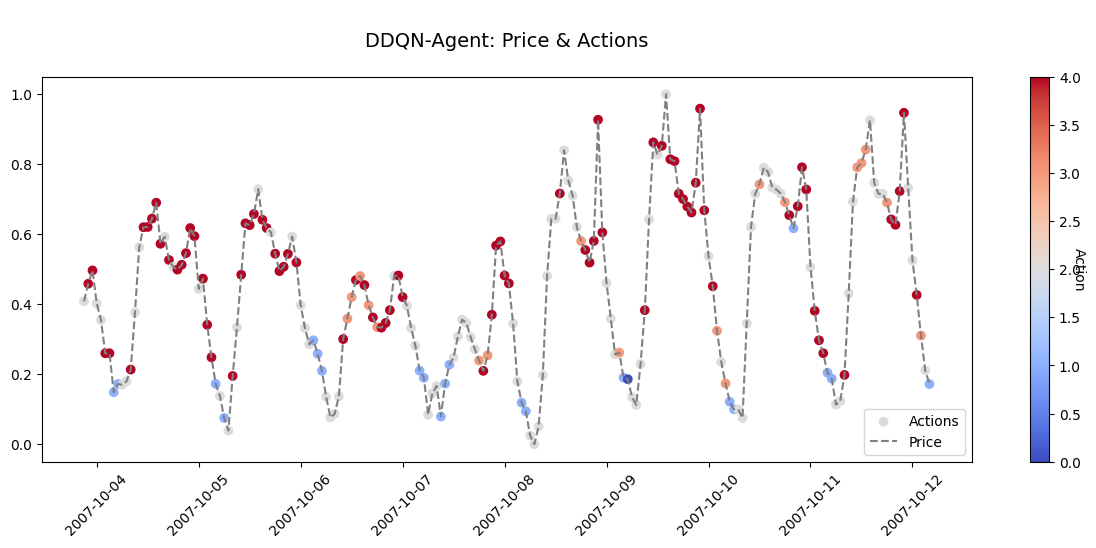

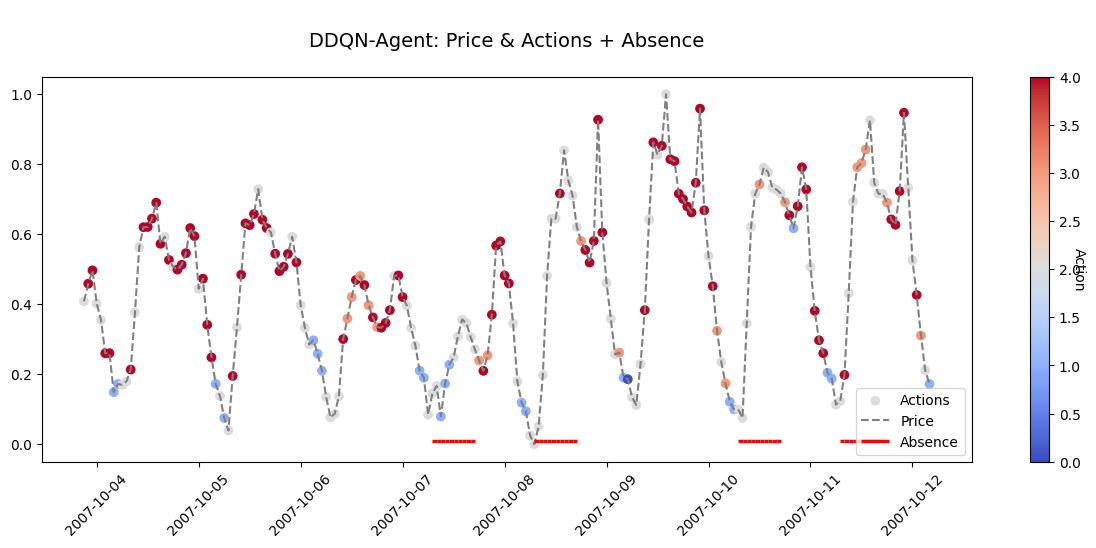

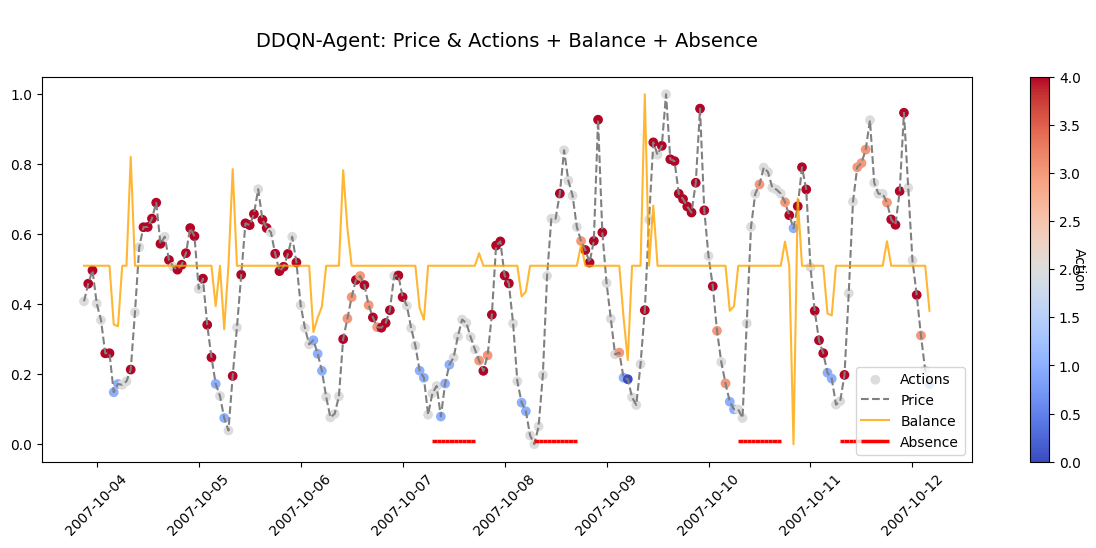

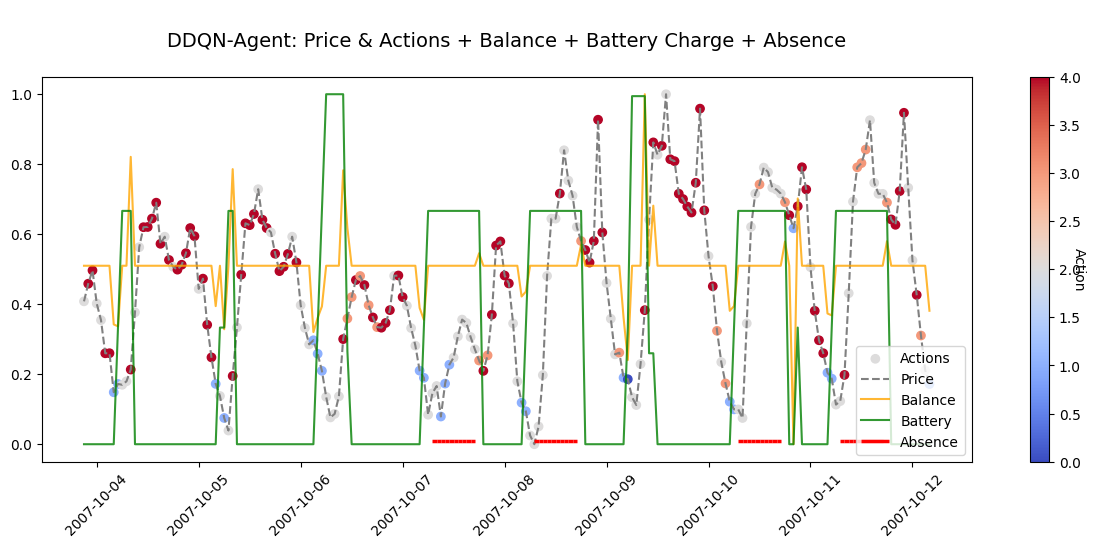

In [13]:
## Training Evaluation of Temporal Agent:
price_horizon = 120
action_classes = 5
df = train

temp_env_train = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
temp_env_train.setup(df, price_horizon=price_horizon, action_classes = action_classes)
eval_temp_train = DDQNEvaluation(df, temp_env_train)
eval_temp_train.evaluate(agent = temporal_agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_temp_train, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

Setup with price horizon:  120  and future horizon:  0  and action space:  5
Absolute Balance:  -729.2133127565556


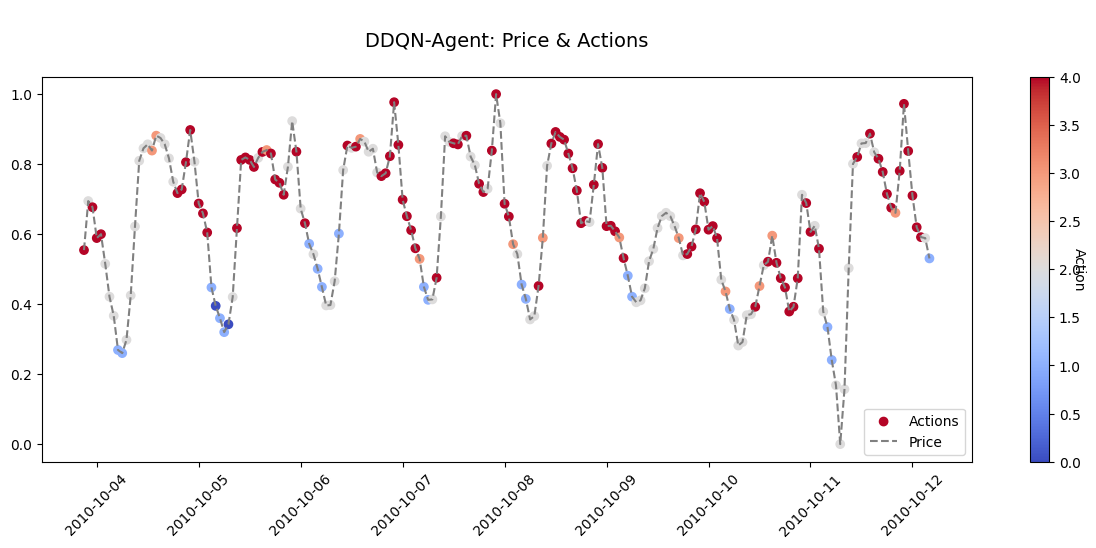

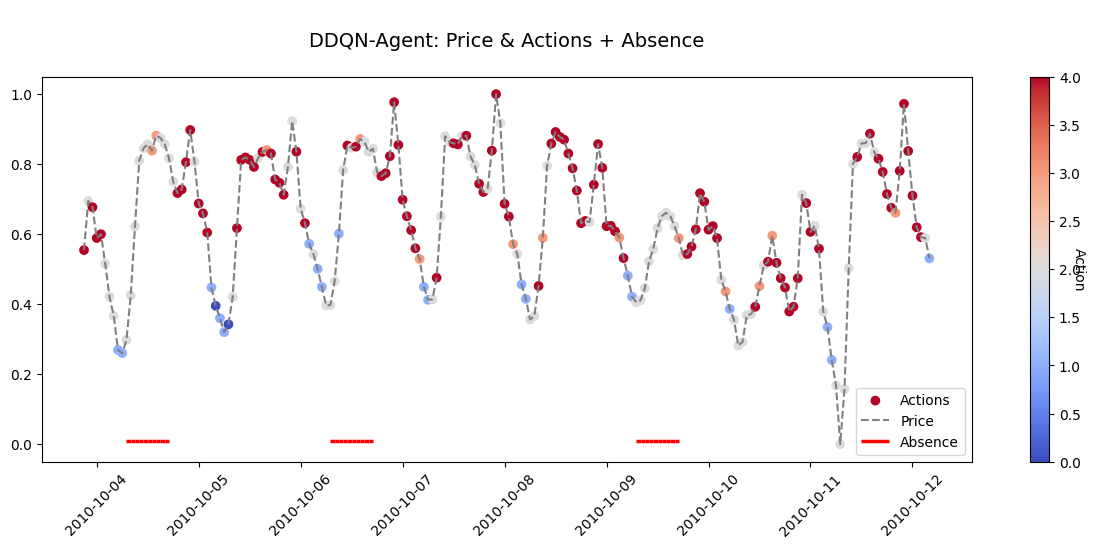

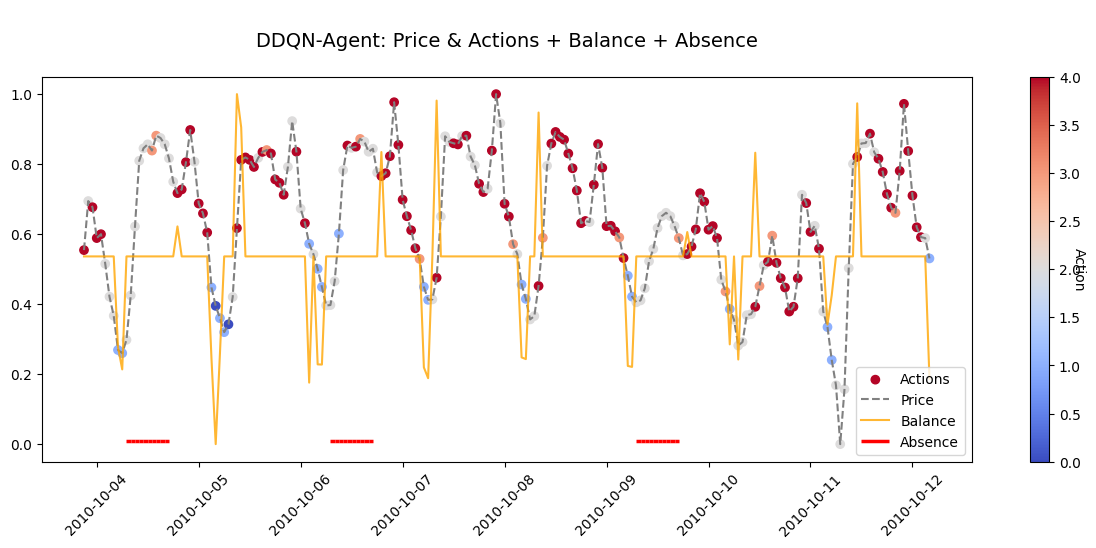

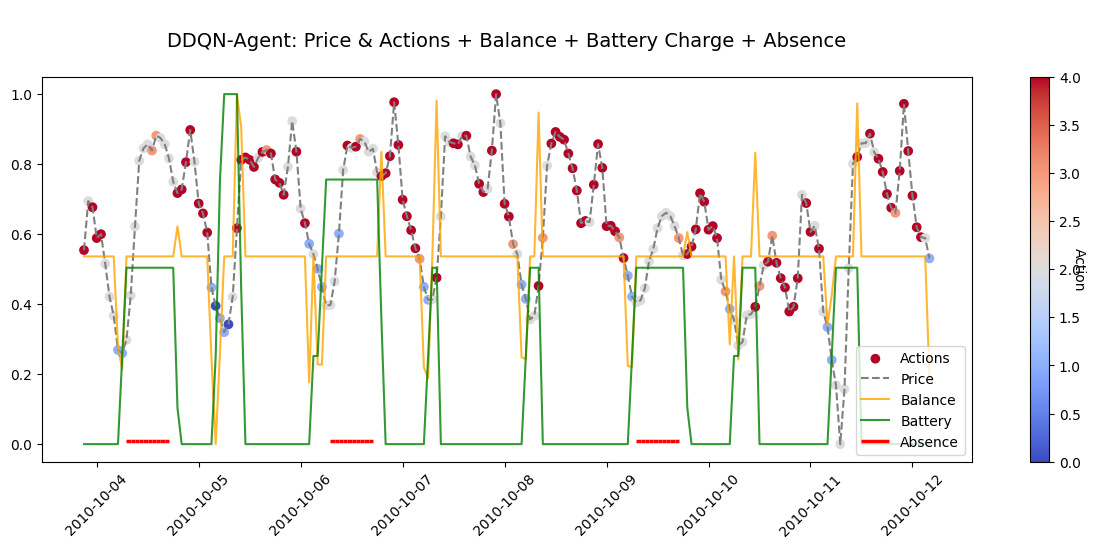

In [14]:
## Validation of Temporal Agent:
price_horizon = 120
action_classes = 5
df = val

temp_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
temp_env_val.setup(df, price_horizon=price_horizon, action_classes = action_classes)
eval_temp_val = DDQNEvaluation(df, temp_env_val)
eval_temp_val.evaluate(agent = temporal_agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_temp_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

# Sanity Check of Environment

In [ ]:
action_classes = 11
test_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
test_env.setup(df, price_horizon=price_horizon, extra_penalty = True, action_classes = action_classes, verbose = True)
obs, info = test_env.reset()

for k in range(4):
    for i in reversed(range(action_classes)):
        test_env.step(i)


In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering:

# ⁠Gradient of curve
# Value of to same date last year if available
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


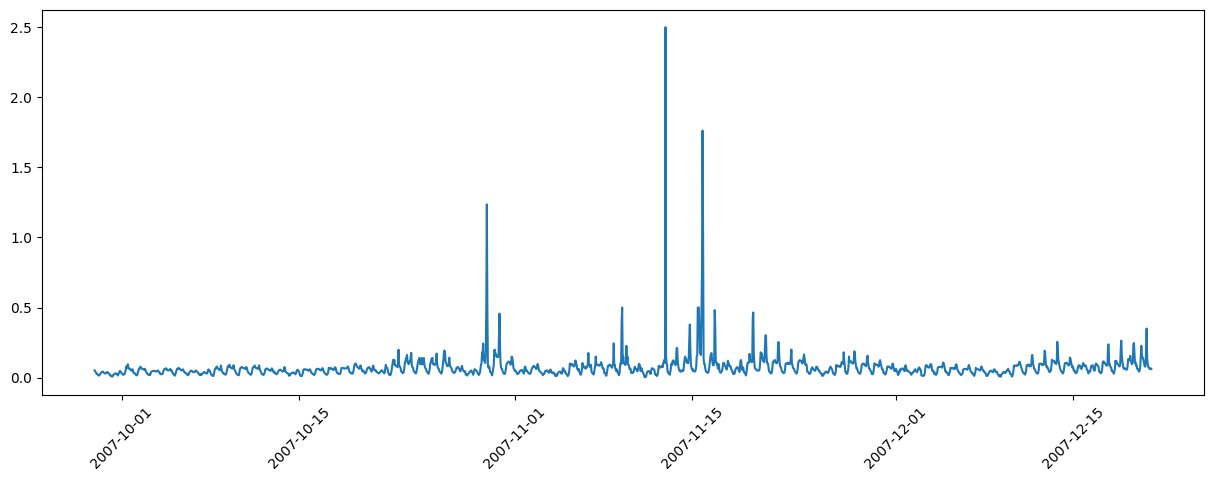

In [ ]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

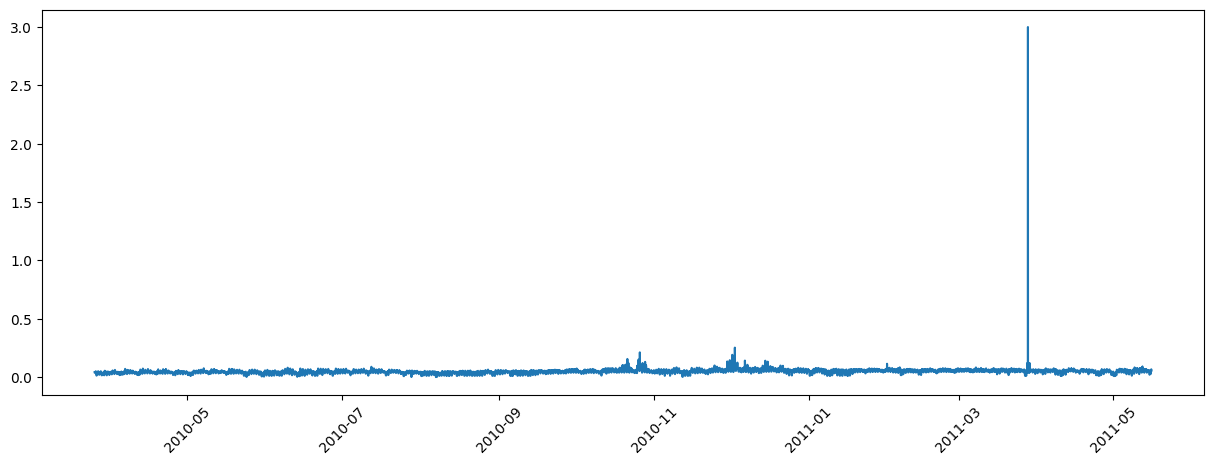

In [ ]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [ ]:
price_horizon = 48
future_horizon = 0

env = gym.make('gym_env/BatteryGrid-v0')
env.setup(val, price_horizon=price_horizon, future_horizon=future_horizon, verbose=True)
obs,_ = env.reset()
print(obs)

obs,r,t,info = env.step(0)
obs,r,t,info = env.step(1)
obs,r,t,info = env.step(2)
obs,r,t,info = env.step(3)
obs,r,t,info = env.step(4)
obs,r,t,info = env.step(5)
obs,r,t,info = env.step(6)
obs,r,t,info = env.step(7)
obs,r,t,info = env.step(8)
obs,r,t,info = env.step(9)
obs,r,t,info = env.step(10)
obs,r,t,info = env.step(11)




{'battery': -0.5, 'prices': array([-0.76523653, -0.76929427, -0.85788829, -1.01614022, -1.07430118,
       -1.17642101, -1.38336583, -1.59031066, -1.08985586, -1.04183925,
       -0.96947619, -0.74089008, -0.43926462, -0.6421517 , -0.80716652,
       -0.96947619, -0.99449893, -0.38719027, -0.12276077,  0.37498886,
        0.18833275, -0.03957707,  0.60695643,  0.44261789, -0.10247207,
       -0.47781316, -0.36487269, -0.7949933 , -0.9687999 , -0.84706765,
       -0.59954541, -0.06865755,  0.29653919,  0.85244979,  1.17030622,
        1.36440153,  1.52062458,  1.12499477,  0.99649962,  0.70569481,
        0.86191786,  1.50980393,  2.16242404,  2.13266727,  1.41918104,
        1.00123365,  1.25010847,  1.11958445]), 'hour': -0.4583333333333333, 'day': -0.4904109589041096, 'presence': 1, 'tensor': array([-0.5       , -0.76523653, -0.76929427, -0.85788829, -1.01614022,
       -1.07430118, -1.17642101, -1.38336583, -1.59031066, -1.08985586,
       -1.04183925, -0.96947619, -0.74089008, -0.4

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

In [ ]:
action = 2
kWh = (6 - action) * 5 # Discretize, such that action 0 means most discharge, i.e., kWh = (5 - 0)* 5 = 25
kWh  -= 2.23 if action == 0 else 0 # Add charging loss

print(kWh)

20
